In [3]:
# Importação das bibliotecas necessárias


import pandas as pd
import numpy as np

import datetime as dt

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [1]:
# Algumas importações relativos ao Spark que iremos usar daqui em diante

import sys

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

from pyspark.ml import Pipeline
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import Imputer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
0,application_1649537342906_0001,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
# Criação de uma sessão spark

spark = SparkSession\
    .builder\
    .appName("AirBnB")\
    .config("spark.sql.shuffle.partitions",6)\
    .getOrCreate()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
# Ver o caminho para a pasta contendo o dataset

! pwd

/home/big/praticas/Trabalho_Grupo


In [3]:
# Ler o dataset

taxis_and_limosines = spark.read.csv('s3://bruhcket/Dados/big data/', header="true", inferSchema="true", sep=',')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
# Informações sobre os dados - 5 primeiras linhas, o esquema e o número total de registos

taxis_and_limosines.show(5, vertical = True)

taxis_and_limosines.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

-RECORD 0----------------------------------
 vendor_id           | CMT                 
  pickup_datetime    | 2014-08-16 14:58:49 
  dropoff_datetime   | 2014-08-16 15:15:59 
  passenger_count    | 1                   
  trip_distance      | 2.7                 
  pickup_longitude   | -73.946537          
  pickup_latitude    | 40.776813           
  rate_code          | 1                   
  store_and_fwd_flag | N                   
  dropoff_longitude  | -73.976193          
  dropoff_latitude   | 40.755625           
  payment_type       | CSH                 
  fare_amount        | 14.0                
  surcharge          | 0.0                 
  mta_tax            | 0.5                 
  tip_amount         | 0.0                 
  tolls_amount       | 0.0                 
  total_amount       | 14.5                
-RECORD 1----------------------------------
 vendor_id           | CMT                 
  pickup_datetime    | 2014-08-16 08:10:48 
  dropoff_datetime   | 2014-08-1

In [5]:
taxis_and_limosines.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- vendor_id: string (nullable = true)
 |--  pickup_datetime: string (nullable = true)
 |--  dropoff_datetime: string (nullable = true)
 |--  passenger_count: integer (nullable = true)
 |--  trip_distance: double (nullable = true)
 |--  pickup_longitude: double (nullable = true)
 |--  pickup_latitude: double (nullable = true)
 |--  rate_code: integer (nullable = true)
 |--  store_and_fwd_flag: string (nullable = true)
 |--  dropoff_longitude: double (nullable = true)
 |--  dropoff_latitude: double (nullable = true)
 |--  payment_type: string (nullable = true)
 |--  fare_amount: double (nullable = true)
 |--  surcharge: double (nullable = true)
 |--  mta_tax: double (nullable = true)
 |--  tip_amount: double (nullable = true)
 |--  tolls_amount: double (nullable = true)
 |--  total_amount: double (nullable = true)

In [ ]:
# Significado das colunas:

# vendor_id - Um código em string indicando o provedor associado ao registo de viagem
# pickup_datetime - Data do início da viagem
# dropoff_datetime - Data do fim da viagem
# passenger_count - Número de passageiros da viagem
# trip_distance - Distância da viagem
# pickup_longitude - Longitude do sítio de início da viagem
# pickup_latitude - Latitude do sítio de início da viagem
# rate_code - Tarifa da rota
# store_and_fwd_flag - Se o registo da viagem foi guardado na memória do veículo antes de ter sido enviado para o provedor
# dropoff_longitude - Longitude do fim da viagem
# dropoff_latitude - Latitude do fim da viagem
# payment_type - Tipo de pagamento 
# fare_amount - Valor das tarifas da viagem
# surcharge - Valor das sobretaxas da viagem
# mta_tax - Imposto cobrado a serviços prestados da área dos transportes
# tip_amount - Valor da gorjeta
# tolls_amount - Valor das portagens da viagem
# total_amount - Total pago pela viagem

In [6]:
# Vamos ver se existem NULLS

[taxis_and_limosines.count(), taxis_and_limosines.dropna().count()]

# Quase metade das linhas do dataset inteiro têm pelo menos um registo NULL

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[25795242, 12484250]

In [8]:
# Adição da variável Trip Duration à subamostra para efeitos de implementação do algoritmo

taxis_and_limosines = taxis_and_limosines.withColumn(' pickup_datetime', to_timestamp(" pickup_datetime","yyyy-MM-dd HH:mm:ss"))
taxis_and_limosines = taxis_and_limosines.withColumn(' dropoff_datetime',to_timestamp(" dropoff_datetime","yyyy-MM-dd HH:mm:ss"))
taxis_and_limosines = taxis_and_limosines.withColumn(' trip_duration',col(" dropoff_datetime").cast("long") - col(' pickup_datetime').cast("long"))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [9]:
# Valores na coluna rate_count

taxis_and_limosines.select(taxis_and_limosines.columns[7]).distinct().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+
| rate_code|
+----------+
|         2|
|         5|
|         4|
|       210|
|         1|
|         6|
|       208|
|         3|
|         0|
|         7|
|         9|
|         8|
|       221|
+----------+

In [10]:
# Existem valores inválidos no dataset para esta coluna (rate_code), vamos eliminá-los caso apareçam na nossa subamostra

taxis_and_limosines = taxis_and_limosines[taxis_and_limosines[' rate_code'] < 7]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [12]:
taxis_and_limosines.select(taxis_and_limosines.columns[7]).distinct().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+
| rate_code|
+----------+
|         2|
|         5|
|         4|
|         1|
|         6|
|         3|
|         0|
+----------+

In [11]:
# Diferentes tipos de pagamento utilizados

taxis_and_limosines.select(taxis_and_limosines.columns[11]).distinct().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------+
| payment_type|
+-------------+
|          DIS|
|          UNK|
|          CRD|
|          CSH|
|          NOC|
+-------------+

In [13]:
# Informação relevante sobre a coluna_passenger

taxis_and_limosines.select(taxis_and_limosines.columns[3]).distinct().sort(taxis_and_limosines.columns[3]).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------------+
| passenger_count|
+----------------+
|               0|
|               1|
|               2|
|               3|
|               4|
|               5|
|               6|
|               7|
|               8|
|               9|
+----------------+

In [14]:
# Informação relevante sobre a coluna store_and_fwd_flag

taxis_and_limosines.groupBy(taxis_and_limosines.columns[8]).count().show(vertical=True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

-RECORD 0-----------------------
  store_and_fwd_flag | null     
 count               | 13310989 
-RECORD 1-----------------------
  store_and_fwd_flag | N        
 count               | 12216380 
-RECORD 2-----------------------
  store_and_fwd_flag | Y        
 count               | 267838

In [15]:
# Medidas descritivas para cada coluna

for cl in taxis_and_limosines.columns:
    taxis_and_limosines.describe(cl).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+---------+
|summary|vendor_id|
+-------+---------+
|  count| 25795207|
|   mean|     null|
| stddev|     null|
|    min|      CMT|
|    max|      VTS|
+-------+---------+

+-------+
|summary|
+-------+
|  count|
|   mean|
| stddev|
|    min|
|    max|
+-------+

+-------+
|summary|
+-------+
|  count|
|   mean|
| stddev|
|    min|
|    max|
+-------+

+-------+------------------+
|summary|   passenger_count|
+-------+------------------+
|  count|          25795207|
|   mean|1.7060083681437408|
| stddev| 1.359855334681554|
|    min|                 0|
|    max|                 9|
+-------+------------------+

+-------+-----------------+
|summary|    trip_distance|
+-------+-----------------+
|  count|         25795207|
|   mean|3.028266330640442|
| stddev|3.569097561514351|
|    min|              0.0|
|    max|            100.0|
+-------+-----------------+

+-------+------------------+
|summary|  pickup_longitude|
+-------+------------------+
|  count|          25795207|
|   me

In [16]:
# Eliminação dos valores incorretos da variável trip_duration

taxis_and_limosines = taxis_and_limosines[taxis_and_limosines[' trip_duration'] <= 36000]
taxis_and_limosines = taxis_and_limosines[taxis_and_limosines[' trip_duration'] > 0]

taxis_and_limosines = taxis_and_limosines[taxis_and_limosines[' trip_distance'] > 0]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [19]:
# Informação relevante sobre a coluna payment_type

payment_method = taxis_and_limosines.select(' passenger_count',' trip_distance',' fare_amount',' surcharge',
                                                       ' mta_tax',' tip_amount',' tolls_amount', 
                                                       ' total_amount',' payment_type').groupBy(taxis_and_limosines.columns[11]).sum()

payment_method.show(vertical=True)

payment_method_pandas = payment_method.toPandas()

payment_method_final = payment_method_pandas.transpose()

print(payment_method_final)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

-RECORD 0-------------------------------------
  payment_type         | DIS                  
 sum( passenger_count) | 23484                
 sum( trip_distance)   | 72490.10000000002    
 sum( fare_amount)     | 275321.31            
 sum( surcharge)       | 6105.0               
 sum( mta_tax)         | 8996.0               
 sum( tip_amount)      | 47.62                
 sum( tolls_amount)    | 8405.490000000009    
 sum( total_amount)    | 298875.4200000006    
-RECORD 1-------------------------------------
  payment_type         | UNK                  
 sum( passenger_count) | 249015               
 sum( trip_distance)   | 339824.03000000014   
 sum( fare_amount)     | 1439359.8800000001   
 sum( surcharge)       | 38498.5              
 sum( mta_tax)         | 59601.5              
 sum( tip_amount)      | 258379.25999999998   
 sum( tolls_amount)    | 24028.08999999999    
 sum( total_amount)    | 1822132.2999999993   
-RECORD 2-------------------------------------
  payment_typ

In [21]:
valores_medios = []

for i in range(0, payment_method_final.shape[1]):
    valores_medios.append(payment_method_final[i][8] / payment_method_final[i][1])
    print(payment_method_final[i][0], payment_method_final[i][8] / payment_method_final[i][1])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DIS 12.726768012263696
UNK 7.317359596811434
CRD 10.187162707905447
CSH 7.3726007973563465
NOC 11.404590685893035

In [24]:
# Informação relevante sobre a coluna código de viagem

rate_code = taxis_and_limosines.select(' passenger_count',' trip_distance',' fare_amount',' surcharge',
                                                       ' mta_tax',' tip_amount',' tolls_amount', 
                                                       ' total_amount', ' rate_code').groupBy(taxis_and_limosines.columns[7]).sum().sort(taxis_and_limosines.columns[7])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [25]:
rate_code.show(vertical=True)

rate_code_pandas = rate_code.toPandas()

rate_code_final = rate_code_pandas.transpose()

print(rate_code_final)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

-RECORD 0-------------------------------------
  rate_code            | 0                    
 sum( passenger_count) | 956                  
 sum( trip_distance)   | 2856.799999999999    
 sum( fare_amount)     | 10758.4              
 sum( surcharge)       | 310.96000000000004   
 sum( mta_tax)         | 371.5                
 sum( tip_amount)      | 604.74               
 sum( tolls_amount)    | 129.44               
 sum( total_amount)    | 12175.04             
 sum( rate_code)       | 0                    
-RECORD 1-------------------------------------
  rate_code            | 1                    
 sum( passenger_count) | 42675561             
 sum( trip_distance)   | 6.768620935000041E7  
 sum( fare_amount)     | 2.928283296E8        
 sum( surcharge)       | 8356181.239999999    
 sum( mta_tax)         | 1.2509543E7          
 sum( tip_amount)      | 3.408820334000233E7  
 sum( tolls_amount)    | 4521409.160000311    
 sum( total_amount)    | 3.523100993699713E8  
 sum( rate_co

In [26]:
valores_medios = []

for i in range(0, rate_code_final.shape[1]):
    valores_medios.append(rate_code_final[i][8] / rate_code_final[i][1])
    print(rate_code_final[i][0], rate_code_final[i][8] / rate_code_final[i][1])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

0.0 12.735397489539748
1.0 8.255546994917564
2.0 34.18997681282801
3.0 47.20223257698543
4.0 42.021001796407205
5.0 61.5400599801901
6.0 7.529774436090226

In [28]:
# Conversão da subamostra em pandas

#NOTA os dados sao demasiado grandes para transformarmos em pandas
#logo nao podemos correr a serie temporal a seguir

taxis_and_limosines = taxis_and_limosines.toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

An error was encountered:
An error occurred while calling o217.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Total size of serialized results of 20 tasks (1073.8 MiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2470)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2419)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2418)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2418)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1125)
	at org.apache.spark.scheduler.DAGScheduler.$

Text(0, 0.5, 'Total Amount')

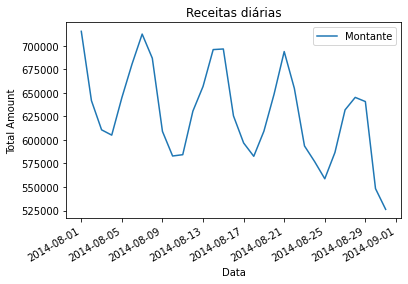

In [69]:
# Gráfico das receitas diárias ao longo do mês

receitas_diarias = subamostra_pandas.groupby(subamostra_pandas[' pickup_datetime'].dt.date).sum()

plt.plot(receitas_diarias.index, receitas_diarias[' total_amount'])
plt.legend(["Montante"])
plt.gcf().autofmt_xdate()
plt.title('Receitas diárias')
plt.xlabel('Data')
plt.ylabel('Total Amount')

In [30]:
numericas = taxis_and_limosines.select(' passenger_count', ' trip_distance', ' pickup_longitude', ' pickup_latitude', ' rate_code', ' store_and_fwd_flag', ' dropoff_longitude', ' dropoff_latitude', ' fare_amount', ' surcharge', ' mta_tax', ' tip_amount', ' tolls_amount', ' trip_duration', ' total_amount')

numericas = numericas.withColumn(' store_and_fwd_flag', when(numericas[' store_and_fwd_flag'] == 'Y', 1).otherwise(0))

for i in numericas.columns:
    print(i, ': ', numericas.stat.corr(i, ' total_amount'))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

 passenger_count :  0.014637863431405558
 trip_distance :  0.9391157739273855
 pickup_longitude :  -0.005533764425310285
 pickup_latitude :  0.005924055354555016
 rate_code :  0.5819343725487813
 store_and_fwd_flag :  0.012108471621690086
 dropoff_longitude :  -0.006536415201365466
 dropoff_latitude :  0.006702587535749901
 fare_amount :  0.9827932148034818
 surcharge :  -0.046329971625638684
 mta_tax :  -0.30125667027893965
 tip_amount :  0.6602325764039984
 tolls_amount :  0.6811384469880634
 trip_duration :  0.8253101787376363
 total_amount :  1.0

In [32]:
# Guardar o ficheiro representativo da subamostra para utilizar no notebook contendo apenas o algoritmo

taxis_and_limosines.write.mode("overwrite").csv("taxis_and_limosines_Full",header=True)

VBox()

An error was encountered:
Session 0 did not reach idle status in time. Current status is busy.


In [34]:
# Implementação do algoritmo utilizando os preditores mais correlacionados com a variável alvo

vectorAssembler = VectorAssembler(inputCols = [' trip_distance', ' rate_code', ' fare_amount', ' tip_amount', ' tolls_amount', ' trip_duration'], outputCol = 'features')

vhouse_df = vectorAssembler.transform(taxis_and_limosines)

vhouse_df = vhouse_df.select(['features', ' total_amount'])

vhouse_df.show(3)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-------------+
|            features| total_amount|
+--------------------+-------------+
|[2.7,1.0,14.0,0.0...|         14.5|
|[20.4,1.0,58.5,0....|        64.33|
|[2.1,1.0,9.5,0.0,...|         10.0|
+--------------------+-------------+
only showing top 3 rows

In [35]:
splits = vhouse_df.randomSplit([0.7, 0.3])

subamostra_treino = splits[0]

subamostra_teste = splits[1]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [37]:
lr = LinearRegression(featuresCol = 'features', labelCol = ' total_amount', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(subamostra_treino)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [38]:
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

RMSE: 1.167750
r2: 0.991274

In [40]:
# Avaliação da performance preditiva sobre o conjunto de teste

lr_predictions = lr_model.transform(subamostra_teste)
lr_predictions.select('prediction', ' total_amount', 'features').show(5)
from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol = 'prediction', \
                 labelCol= ' total_amount', metricName = 'r2')
print('R quadrado sobre o conjunto de teste = %g' % lr_evaluator.evaluate(lr_predictions))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------+-------------+--------------------+
|        prediction| total_amount|            features|
+------------------+-------------+--------------------+
|3.9349549562690376|          3.0|[0.01,1.0,2.5,0.0...|
|3.9349549562690376|          3.0|[0.01,1.0,2.5,0.0...|
|3.9349549562690376|          3.0|[0.01,1.0,2.5,0.0...|
|3.9349549562690376|          3.0|[0.01,1.0,2.5,0.0...|
|3.9349549562690376|          3.0|[0.01,1.0,2.5,0.0...|
+------------------+-------------+--------------------+
only showing top 5 rows

R quadrado sobre o conjunto de teste = 0.991441

In [41]:
test_result = lr_model.evaluate(subamostra_teste)
print('Root Mean Squared Error (RMSE) no conjunto de treino = %g' % test_result.rootMeanSquaredError)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Root Mean Squared Error (RMSE) no conjunto de treino = 1.15665

In [44]:
predictions = lr_model.transform(subamostra_teste)
predictions.select('prediction', ' total_amount','features').show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------+-------------+--------------------+
|        prediction| total_amount|            features|
+------------------+-------------+--------------------+
|3.9349549562690376|          3.0|[0.01,1.0,2.5,0.0...|
|3.9349549562690376|          3.0|[0.01,1.0,2.5,0.0...|
|3.9349549562690376|          3.0|[0.01,1.0,2.5,0.0...|
|3.9349549562690376|          3.0|[0.01,1.0,2.5,0.0...|
|3.9349549562690376|          3.0|[0.01,1.0,2.5,0.0...|
|3.9349549562690376|          3.0|[0.01,1.0,2.5,0.0...|
|3.9349549562690376|          3.0|[0.01,1.0,2.5,0.0...|
|3.9349549562690376|          3.5|[0.01,1.0,2.5,0.0...|
|3.9349549562690376|          3.5|[0.01,1.0,2.5,0.0...|
|3.9349549562690376|          3.5|[0.01,1.0,2.5,0.0...|
|3.9349549562690376|          3.5|[0.01,1.0,2.5,0.0...|
|3.9349549562690376|          3.5|[0.01,1.0,2.5,0.0...|
|3.9349549562690376|          4.0|[0.01,1.0,2.5,0.0...|
|3.9349549562690376|          4.0|[0.01,1.0,2.5,0.0...|
|3.9349549562690376|          4.0|[0.01,1.0,2.5,